In [2]:
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from utils import preview

# Functions

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def image_kmeans(img, K=2, attempts=50, color_space=None, preview_image=False, plot_results=False):
    # Preprocessing
    img = img.copy()
    img = cv2.blur(img, (5, 5))
    if color_space is not None:
        img = cv2.cvtColor(img, color_space)
    img_flat = np.float32(img.reshape((-1,3)))
    
    # K means
    _, labels, center = cv2.kmeans(
        img_flat,
        K,
        None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
        attempts,
        cv2.KMEANS_RANDOM_CENTERS
    )
    center = np.uint8(center)
    
    # View segmented image 
    if preview_image:
        res = center[labels.flatten()]
        result_img = res.reshape((img.shape))
        preview(result_img)
    
    # View k-means centroids in 3D
    if plot_results:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(center.T[0], center.T[1], center.T[2], c=center/255, s=200, alpha=1)
        for i in range(center.shape[0]):
            ax.text(center.T[0, i], center.T[1, i], center.T[2, i], i, fontsize=14)
        ax.set_xlim(0,256)
        ax.set_ylim(0,256)
        ax.set_zlim(0,256)
        plt.show()
    
    return labels

# Main Class 

In [4]:
class VideoSegment:
    def __init__(self, path, start, finish, y_min=1400, kmeans_color_space=None):
        """
        Load and analyse a video segment.
        Contains methods to extract a bounding box and crop images using that bounding box
        Arguments:
        - path: path to load video
        - start: video starting point, in seconds
        - finish: video end point, in seconds
        - y_min: y coordinate used to crop the bottom part of the image
        """
        # Store the arguments
        self.filename = path.split('/')[-1].replace('.mp4', '')
        self.vidcap = cv2.VideoCapture(path)
        self.fps = self.vidcap.get(cv2.CAP_PROP_FPS)
        self.first_frame = int(start * self.fps)
        self.last_frame = int(finish * self.fps)
        self.y_min = y_min
        self.kmeans_color_space = kmeans_color_space
        
        # Detect bounding box, crop image and segment image to find background pixels
        self.bbox_image = self.get_frame(self.first_frame)
        self.bbox = self._get_bbox(self.bbox_image)
        self.bbox_image_cropped = self._crop_bbox(self.bbox_image)
        self.alpha_channel = self._segment_object(self.bbox_image_cropped)
        
    def get_frame(self, frame):
        """
        Fetch particular frame from video segment and preprocess it
        """
        self.vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame)
        _, image = self.vidcap.read()
        image = self._preprocess_image(image)
        return image
            
    def _preprocess_image(self, image):
        """
        Utility function: rotate, colorise and crop the image
        """
        image = image.copy()
        image = np.rot90(image, 3)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image[self.y_min:]
        return image
    
    def _get_bbox(self, image):
        """
        Find the bounding box of the object using edge detection and hough transform
        """
        image = image.copy()
        
        # Scale image and find edges
        resize = 2  # 2 means half size
        width, height = int(image.shape[1] / resize), int(image.shape[0] / resize)
        image_small = cv2.resize(image, (width, height))
        image_edges = cv2.Canny(image_small, 50, 100)

        # In hindsight, the rest of this function could have been done with cv2.findContours
        # see https://github.com/geaxgx/playing-card-detection/
        
        # Hough transform
        hough_args = {
            'rho': 1,
            'theta': np.pi/180,
            'threshold': 30,
            'minLineLength': 30,
            'maxLineGap': 10
        }
        hough_lines = cv2.HoughLinesP(image_edges, **hough_args)
        if hough_lines is None:
            raise ValueError('Could not identify any objects in the image!')
        hough_lines = hough_lines * resize
        
        # Get bounding box of hough lines - add padding for the segmentation
        padding = 1
        bbox = {'xmin': image_edges.shape[1], 'xmax': 0, 'ymin': image_edges.shape[0], 'ymax': 0}
        for line in hough_lines:
            for x1,y1,x2,y2 in line:
                bbox['xmin'] = min(bbox['xmin'], x1, x2) - padding
                bbox['xmax'] = max(bbox['xmax'], x1, x2) + padding
                bbox['ymin'] = min(bbox['ymin'], y1, y2) - padding
                bbox['ymax'] = max(bbox['ymax'], y1, y2) + padding
        return bbox
        
    def draw_bbox(self, image):
        """
        Draw bounding box on input image
        """
        image = image.copy()
        
        kwargs = {'img': image, 'color': (255,0,0), 'thickness': 5}
        cv2.line(pt1=(self.bbox['xmin'], self.bbox['ymin']),
                 pt2=(self.bbox['xmin'], self.bbox['ymax']),
                 **kwargs)
        cv2.line(pt1=(self.bbox['xmin'], self.bbox['ymin']),
                 pt2=(self.bbox['xmax'], self.bbox['ymin']),
                 **kwargs)
        cv2.line(pt1=(self.bbox['xmax'], self.bbox['ymax']),
                 pt2=(self.bbox['xmin'], self.bbox['ymax']),
                 **kwargs)
        cv2.line(pt1=(self.bbox['xmax'], self.bbox['ymax']),
                 pt2=(self.bbox['xmax'], self.bbox['ymin']),
                 **kwargs)
        preview(image)
    
    def _crop_bbox(self, image):
        """
        Crop the image according to the bounding box coordinates
        """
        image = image.copy()
        image_cropped = image[self.bbox['ymin']:self.bbox['ymax'],
                              self.bbox['xmin']:self.bbox['xmax']]
        return image_cropped
    
    def _segment_object(self, image):
        """
        Segments the image into two color clusters, then makes the background transparent
        The background color is identified as the color which appears most in the 4 corners
        """
        image = image.copy()
        
        # Apply k means to separate the sticky note from the background
        labels = image_kmeans(image, K=2, color_space=self.kmeans_color_space)
        
        # The background label is the one which appears in all 4 corners
        pixel_labels = labels.T[0].reshape(image[:, :, 0].shape)
        corner_labels = np.array([pixel_labels[0, 0], pixel_labels[0, -1],
                                  pixel_labels[-1, 0], pixel_labels[-1, -1]])
        unique_labels = np.unique(corner_labels)
        if len(unique_labels) == 1:
            background_label = unique_labels[0]
        else:
            raise ValueError('Background could not be identified!')
        
        # Create alpha channel and set it to 0 for the background
        alpha_channel = np.ones(pixel_labels.shape, dtype='uint8') * 255
        alpha_channel[pixel_labels == background_label] = 0
        # Set alpha=0 for the background which blurred into the object during k-means segmentation
        padding = 3
        for matrix in [alpha_channel, alpha_channel.T]:
            for dim in matrix:  # iterates over rows or columns (matrix or matrix.T)
                dim_values = np.where(dim > 0)[0]
                if dim_values.shape[0] > 0:
                    dim[dim_values[:padding]] = 0
                    dim[dim_values[-padding:]] = 0
        return alpha_channel
        
    def _remove_background(self, image, alpha_channel=None):
        """
        Segments the image into two color clusters, then makes the background transparent
        The background color is identified as the color which appears most in the 4 corners
        """
        image = image.copy()
        if alpha_channel is None:
            alpha_channel = self.alpha_channel
        image_transparent = cv2.merge((*cv2.split(image), alpha_channel))
        return image_transparent
        
    def process_image(self, image):
        """
        Whole image processing pipeline:
        - rotate, colorise and crop lower half of image
        - crop object using the object bounding box found in the first frame
        - remove background using segmentation found in the first frame
        """
        image = image.copy()
        image_cropped = self._crop_bbox(image)
        image_transparent = self._remove_background(image_cropped)
        return image_transparent

    def process_video(self, framerate=10, skip=0, preview_image=False, save_path=None):
        """
        Apply image processing pipeline to each frame of the video
        Arguments:
        - framerate: frequency at which to extract video frames
        - skip: number of frames to skip
        - preview_image: whether to preview the loaded and processed images
        - save_path: folder to save the results in - the filename will be taken from the video
        """        
        for frame in range(self.first_frame + skip, self.last_frame, framerate):
            image = self.get_frame(frame)
            image_transparent = self.process_image(image)
            if preview_image:
                print(f'Frame {frame} ({round(frame/self.fps, 2)} seconds)')
                preview(image)
                preview(image_transparent)
            if save_path is not None:
                cv2.imwrite(
                    os.path.join(save_path, f'{self.filename}-{frame}.png'),
                    cv2.cvtColor(image_transparent, cv2.COLOR_RGBA2BGRA)
                )

# Demo

### 1. Internal methods: Get the bounding box from the first video frame

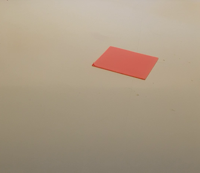

{'xmin': 494, 'xmax': 860, 'ymin': 242, 'ymax': 437}
{'xmin': 494, 'xmax': 860, 'ymin': 242, 'ymax': 437}


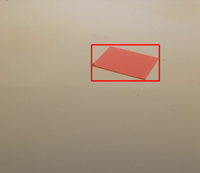

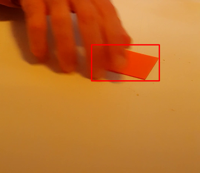

In [5]:
# Create instance of VideoSegment class
segment = VideoSegment('../data/raw/videos/day2/salmon1.mp4', start=5, finish=15, y_min=1400)

# Load frame from video
image = segment.get_frame(150)
preview(image)

# When the object was created, the bounding box was calculated using the first video frame
print(segment.bbox)
# ... this is the result of this call:
print(segment._get_bbox(segment.get_frame(segment.first_frame)))
# We can now draw the bounding box on the image
segment.draw_bbox(image)

# The bounding box is constant for the video segment so that it can be used for other frames
segment.draw_bbox(segment.get_frame(490))

### 2. Internal methods: Crop objects using the bounding box and segmentation

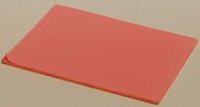

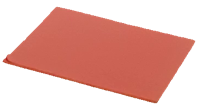

In [6]:
# Crop the image using the bounding box
cropped_image = segment._crop_bbox(image)
preview(cropped_image)

# Segment the image using k-means
alpha_channel = segment._segment_object(cropped_image).copy()
transparent_image = segment._remove_background(cropped_image, alpha_channel)
preview(transparent_image)

### 3. Exposed API: Crop objects from a single frame in a video segment

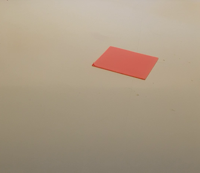

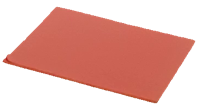

In [7]:
# Create instance of VideoSegment class
segment = VideoSegment('../data/raw/videos/day2/salmon1.mp4', start=5, finish=15, y_min=1400)

# Get image
image = segment.get_frame(150)
preview(image)

# Get output image
transparent_image = segment.process_image(image)
preview(transparent_image)

### 4. Exposed API: Crop objects from all frames in a video segment

Frame 270 (8.99 seconds)


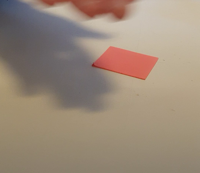

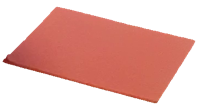

Frame 390 (12.99 seconds)


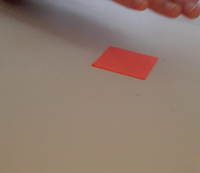

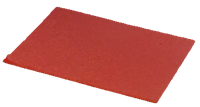

In [8]:
# Create instance of VideoSegment class
segment = VideoSegment('../data/raw/videos/day2/salmon1.mp4', start=5, finish=16, y_min=1400)

# Process all frames in the video
segment.process_video(preview_image=True, framerate=120, skip=120)

# Image extraction

In [9]:
segment_configs = {
    'salmon1': [
        {
            'start': 5,
            'finish': 16
        },
#         {
#             'start': 20,
#             'finish': 31
#         },
#         {
#             'start': 35,
#             'finish': 45
#         },
#         {
#             'start': 49,
#             'finish': 59
#         }
#     ],
#     'salmon2': [
#         {
#             'start': 5,
#             'finish': 15,
#         },
#         {
#             'start': 21,
#             'finish': 31
#         },
#         {
#             'start': 36,
#             'finish': 46
#         },
#         {
#             'start': 51,
#             'finish': 61
#         }
#     ],
#     'yellow': [
#         {
#             'start': 5,
#             'finish': 15,
#             'kmeans_color_space': cv2.COLOR_RGB2HLS
#         },
#         {
#             'start': 20,
#             'finish': 30,
#             'kmeans_color_space': cv2.COLOR_RGB2HLS,
#             'y_min': 1900
#         },
#         {
#             'start': 35,
#             'finish': 45,
#             'kmeans_color_space': cv2.COLOR_RGB2HLS
#         },
#         {
#             'start': 53,
#             'finish': 61,
#             'kmeans_color_space': cv2.COLOR_RGB2HLS
#         }
#     ],
#     'pink': [
#         {
#             'start': 5,
#             'finish': 15,
#         },
#         {
#             'start': 20,
#             'finish': 30,
#         },
#         {
#             'start': 35,
#             'finish': 45
#         },
#         {
#             'start': 50,
#             'finish': 60
#         }
    ]
}

Processing file: ../data/raw/videos/day2/salmon1.mp4
- config: {'start': 5, 'finish': 16}
Frame 150 (5.0 seconds)


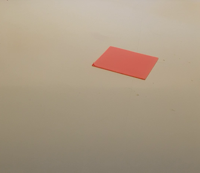

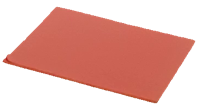

Frame 165 (5.49 seconds)


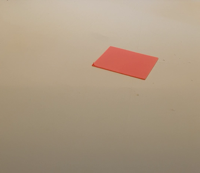

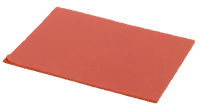

Frame 180 (5.99 seconds)


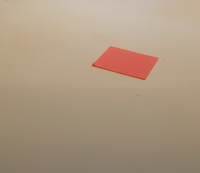

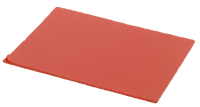

Frame 195 (6.49 seconds)


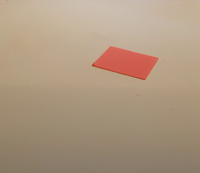

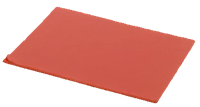

Frame 210 (6.99 seconds)


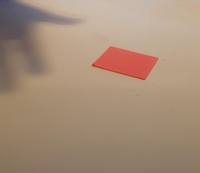

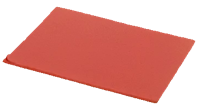

Frame 225 (7.49 seconds)


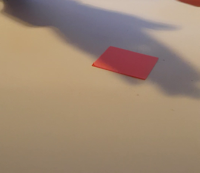

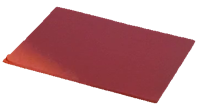

Frame 240 (7.99 seconds)


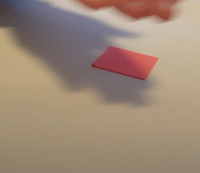

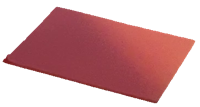

Frame 255 (8.49 seconds)


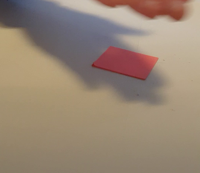

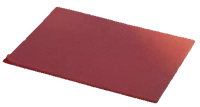

Frame 270 (8.99 seconds)


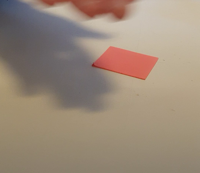

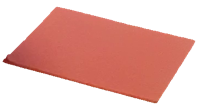

Frame 285 (9.49 seconds)


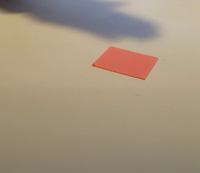

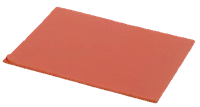

Frame 300 (9.99 seconds)


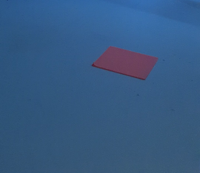

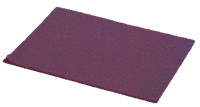

Frame 315 (10.49 seconds)


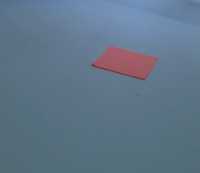

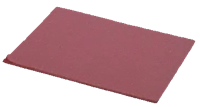

Frame 330 (10.99 seconds)


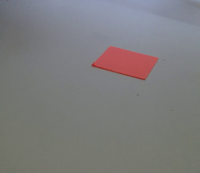

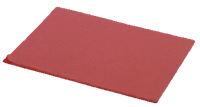

Frame 345 (11.49 seconds)


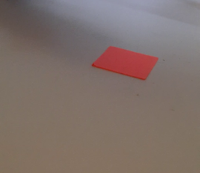

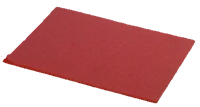

Frame 360 (11.99 seconds)


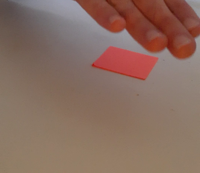

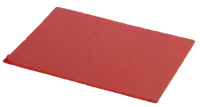

Frame 375 (12.49 seconds)


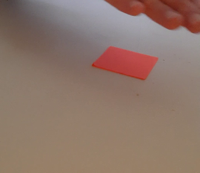

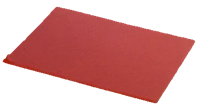

Frame 390 (12.99 seconds)


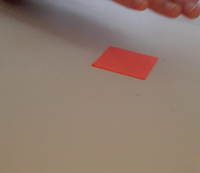

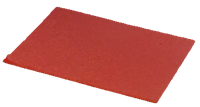

Frame 405 (13.49 seconds)


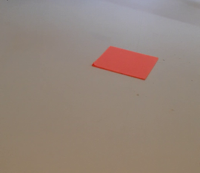

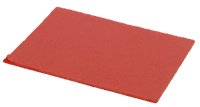

Frame 420 (13.99 seconds)


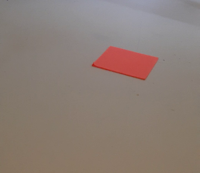

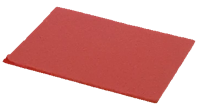

Frame 435 (14.49 seconds)


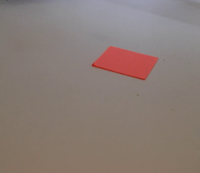

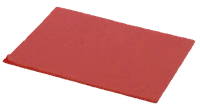

Frame 450 (14.99 seconds)


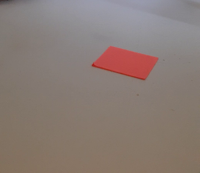

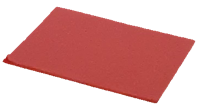

Frame 465 (15.48 seconds)


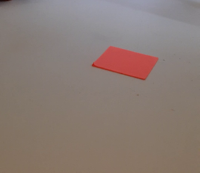

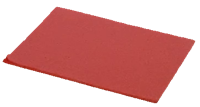

In [10]:
frames_per_segment = 20
fps = 29
for file in segment_configs.keys():
    path = f'../data/raw/videos/day2/{file}.mp4'
    print('Processing file:', path)
    for config in segment_configs[file]:
        print('- config:', config)
        # Create instance of VideoSegment class
        segment = VideoSegment(
            path=path,
            **config
        )
        # Process all frames in the video
        framerate = int(fps / (frames_per_segment / (config['finish'] - config['start'])))
        segment.process_video(
            framerate=framerate,
            #save_path=f'../data/interim/images/',
            preview_image=True
        )